In [74]:
# dataset
import kagglehub
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# analysis
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
# machine learning
from skopt import BayesSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# deep learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Final Assignment

First, download the dataset from Kaggle

In [19]:
import shutil
path = kagglehub.dataset_download("aayushmishra1512/netflix-stock-data")
shutil.move(path+"/NFLX.csv", "./data")

'./data\\NFLX.csv'

After opening the file, we see it's a CSV file with only numerical values, meaning we don't need to change separator, default_na or anything.

In [59]:
nflx_stock = pd.read_csv("data/NFLX.csv")

## EDA and Data preprocessing

### Data Overview

In [21]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [22]:
nflx_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


In [24]:
nflx_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.7+ KB


In [26]:
print(f"There are {nflx_stock.shape[0] - nflx_stock.drop_duplicates().shape[0]} duplicates")

There are 0 duplicates


In [27]:
print(f"There are {nflx_stock.isna().sum().sum()} missing values")

There are 0 missing values


In [60]:
nflx_stock["Date"] = pd.to_datetime(nflx_stock["Date"])

In date column, we can see there are items only on weekdays. Presumably, because the stock market is closed on weekends. From this information, we can create a new column to indicate which day of the week it is. One might presume more fluctuation and higher volume on monday when market opens (we will ignore holidays for now). 

In [55]:
nflx_stock["Weekday"] = nflx_stock["Date"].dt.weekday

In [30]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Weekday
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,3
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,4
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,1
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,3


### Column distributions

We plot how the prices changed over time. No need to plot all the columns, as differences throughout the day are marginal compared to the overall trend.

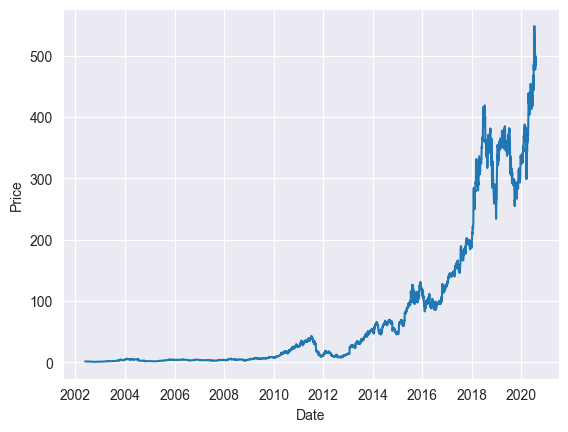

In [45]:
sns.lineplot(data=nflx_stock, x="Date", y="Close")
plt.ylabel("Price")
plt.show()

The price keeps increasing over time, showing the company is growing. Let's see how the volume changes.

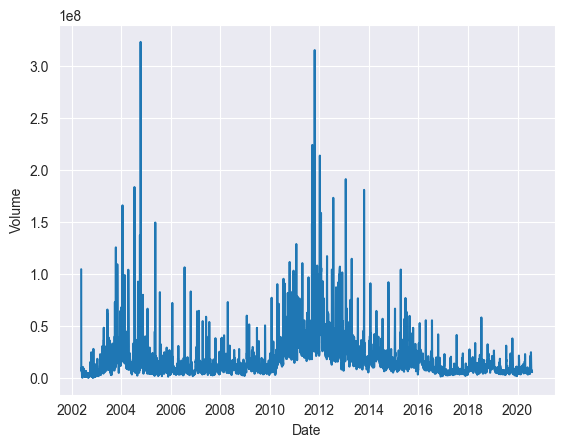

In [50]:
sns.lineplot(data=nflx_stock, x="Date", y="Volume")
plt.show()

The trends in volume aren't as clear compared to the price. We can see two significant spikes in trading volume in late 2004 and in 2012. Overall, later the trading volume is getting lower as time goes.

Let's see how the prices and volumes change depending on the day of the week.

In [59]:
nflx_stock.drop(columns=["Date"]).groupby("Weekday").mean()

,Open,High,Low,Close,Adj Close,Volume
Weekday,,,,,,
0,78.469131,79.860121,77.143506,78.626032,78.626032,1.687406e+07
1,77.886131,79.147035,76.615622,77.938861,77.938861,1.878554e+07
2,77.309623,78.587345,75.987330,77.364613,77.364613,1.775533e+07
3,78.468433,79.703384,77.152493,78.511928,78.511928,1.799244e+07
4,78.068629,79.183218,76.824263,77.970190,77.970190,1.654167e+07


Contrary to our initial assumption, the highest trading volume is in the middle of the workweek, the most on Tuesday. Prices were the highest on Monday though.

Let's visualize how throughout the time, the percentual difference between close and open was the biggest.

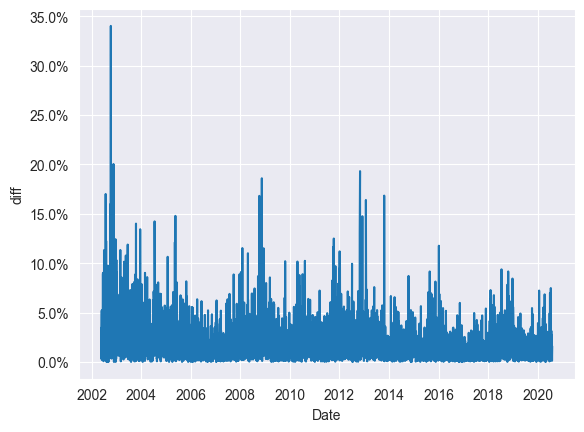

In [28]:
nflx_stock["diff"] = ((nflx_stock["Close"] - nflx_stock["Open"]) / nflx_stock["Open"]).abs()
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We can see, the prices throughout the day have stabilized a bit since the beginning with fewer and smaller spikes since 2014.

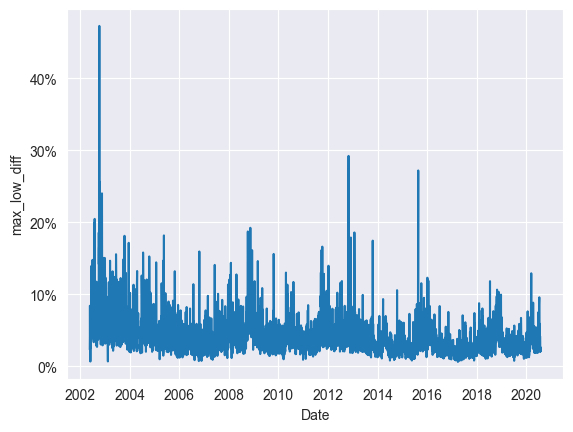

In [30]:
nflx_stock["max_low_diff"] = (nflx_stock["High"] - nflx_stock["Low"]) / nflx_stock["Open"]
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["max_low_diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We cen see that percentual difference between daily maximum and minimum have been decreasing over time as well.

In [46]:
nflx_stock = nflx_stock.drop(columns=["diff", "max_low_diff"])

### Correlation

In [103]:
nflx_stock.corr()

,Date,Open,High,Low,Close,Adj Close,Volume,Weekday
Date,1.000000,0.794332,0.794147,0.794708,0.794371,0.794371,-0.028448,-0.000275
Open,0.794332,1.000000,0.999841,0.999830,0.999654,0.999654,-0.193770,-0.000192
High,0.794147,0.999841,1.000000,0.999783,0.999840,0.999840,-0.192107,-0.000858
Low,0.794708,0.999830,0.999783,1.000000,0.999834,0.999834,-0.195478,-0.000056
Close,0.794371,0.999654,0.999840,0.999834,1.000000,1.000000,-0.193671,-0.000803
Adj Close,0.794371,0.999654,0.999840,0.999834,1.000000,1.000000,-0.193671,-0.000803
Volume,-0.028448,-0.193770,-0.192107,-0.195478,-0.193671,-0.193671,1.000000,-0.011444
Weekday,-0.000275,-0.000192,-0.000858,-0.000056,-0.000803,-0.000803,-0.011444,1.000000


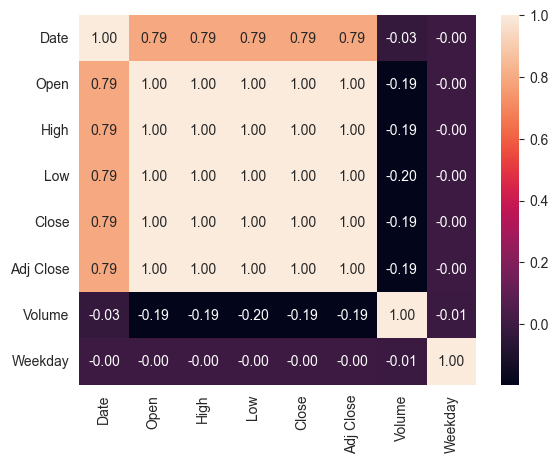

In [107]:
sns.heatmap(nflx_stock.corr(), annot=True, fmt=".2f")
plt.show()

We can see that all the prices are 1.00 correlated with each other, meaning we can likely use only itself to predict itself in the future.  

It also shows that weekday has no correlation with any other column, contradicting our initial assumption, showing the assumptions were coincidental. We can therefore remove the weekday column.

In [56]:
nflx_stock.drop(columns=["Weekday"], inplace=True)

### Scaling
We need to scale the data as volume is in a completely different range compared to all the other columns. For that, we will use MinMax scaling as it best suits our needs.

In [65]:
scaler = MinMaxScaler()
nflx_stock[nflx_stock.columns[1:]] = scaler.fit_transform(nflx_stock[nflx_stock.columns[1:]])

### Transformation
We will find whether we want to transform the data later using Grid Search or Bayes Search.

### Feature Selection
Feature selection will work differently in time series forecasting compared to classification. We will have to use lag/lookback to predict the future, not current state of other columns.  
We will have to adjust the lag and possibly other features and their lag.

As we use lag to depict how data changes over time, we can remove the Date column, as the information that price raises over time will already be contained within the lagged columns 

In [8]:
nflx_stock.drop(columns=["Date"], inplace=True)

In [11]:
def add_lag(df: pd.DataFrame, column, lag=1):
    for i in range(1, lag+1):
        df[f"{column}_lag_{i}"] = df[column].shift(i)
    return df

We add a function that creates a new dataset based on chosen features and their lags. We don't need to worry about adding weekday in there, as there was no correlation between weekday and any other columns based on the heatmap.

In [19]:
def pick_features_with_lags(df: pd.DataFrame, pred_col: str, pred_col_lag: int, **additional_columns):
    df = add_lag(df, pred_col, pred_col_lag)
    selected_columns = [pred_col] + [f"{pred_col}_lag_{lag}" for lag in range(1, pred_col_lag + 1)]
    
    for column, lag in additional_columns.items():
        if lag == 0:
            continue
        df = add_lag(df, column, lag)
        selected_columns.extend([column] + [f"{column}_lag_{i}" for i in range(1, lag + 1)])
    
    return df[selected_columns].dropna() # dropna() to remove rows, where lag was not applicable

In [66]:
# example
pick_features_with_lags(nflx_stock, "Close", 5, Volume=2)

,Close,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Volume,Volume_lag_1,Volume_lag_2
5,0.001283,0.001274,0.001333,0.001430,0.001527,0.001502,0.025311,0.030541,0.020030
6,0.001378,0.001283,0.001274,0.001333,0.001430,0.001527,0.008869,0.025311,0.030541
7,0.001359,0.001378,0.001283,0.001274,0.001333,0.001430,0.008726,0.008869,0.025311
8,0.001412,0.001359,0.001378,0.001283,0.001274,0.001333,0.003856,0.008726,0.008869
9,0.001476,0.001412,0.001359,0.001378,0.001283,0.001274,0.006252,0.003856,0.008726
...,...,...,...,...,...,...,...,...,...
4576,0.890181,0.903202,0.875483,0.870249,0.892570,0.893081,0.017643,0.023450,0.023089
4577,0.882832,0.890181,0.903202,0.875483,0.870249,0.892570,0.019578,0.017643,0.023450
4578,0.885239,0.882832,0.890181,0.903202,0.875483,0.870249,0.019568,0.019578,0.017643
4579,0.890856,0.885239,0.882832,0.890181,0.903202,0.875483,0.017450,0.019568,0.019578


# Finding the best model

Split the data into train and test set. Splitting them randomly makes no sense, as the data is sequential. We split the data at the beginning of 2019 to have roughly 10% of the data as test data.

In [72]:
train = nflx_stock[nflx_stock["Date"] < "2019-01-01"]
test = nflx_stock[nflx_stock["Date"] >= "2019-01-01"]
train.shape[0], test.shape[0]

(4181, 400)

#### We don't define X and y yet, as we are forecasting all values, therefore we will use all columns as y at some point.

## Machine Learning
First, let's try to use the models from sklearn, that are the simplest to use, and see how they perform.

### Linear Regression
Let's begin with the simplest model as the benchmark, Linear Regression. We won't use much tuning, as we don't expect it to perform that well. 

In [ ]:
regressor_close = LinearRegression()
